## Jaccard index
Predicts the species of each binary flash sequence by computing the Jaccard index with literature or population references.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools, math
from sklearn.metrics import roc_curve
from jaccard_index import *

Load binary sequence data, labels, and literature references.

In [2]:
# load data
df_path = '../data/real_data/flash_pattern_data.csv'
df = pd.read_csv(df_path, delimiter=',')
# keep only samples with number of flashes > 1
df = df.loc[df['num_flashes'] > 1].reset_index(drop=True) 
# unpack timeseries
df = pd.concat([df.iloc[:,:-1],pd.DataFrame(np.array(list(itertools.zip_longest(*[list(map(float,x.split(","))) for x in list(df.timeseries.values.flatten())],fillvalue=math.nan))).T
)],axis=1)

# load literature sequences (excludes Bw)
literature_sequences = []
literature_labels = []
header = 0
for l in open('../data/literature_sequences_6.csv'):
    if header > 0:
        header -= 1
        continue
    literature_sequences.append([int(float(x)) for x in l.rstrip().split(',')[1:]])
    literature_labels.append(l.rstrip().split(',')[0])

## Classify using Jaccard index with literature references.

In [3]:
acc, prec, rec, conf_mat, y_true, y_pred, y_score, metrics = jaccardLit(df, literature_sequences, literature_labels, 1)
print('Precision =',prec)
print('Recall =',rec)

Precision = 0.23410524355623083
Recall = 0.25554701909887345


In [4]:
spec_labels=['B. wickershamorum', 'P. bethaniensis', 'P. carolinus', 'P. forresti', 'P. frontalis', 'P. knulli', 'P. obscurellus']
print('Overall precision = {0:2.5f}'.format(prec))
print('Overall recall = {0:2.5f}'.format(rec))
for i in [df[df['species']==label].iloc[0].species_label for label in literature_labels]:
    print('{0} precision = {1:2.5f}, recall = {2:2.5f}'.format(spec_labels[i], metrics[str(i)]['precision'], metrics[str(i)]['recall']))

Overall precision = 0.23411
Overall recall = 0.25555
P. bethaniensis precision = 0.00542, recall = 0.07728
P. carolinus precision = 0.54093, recall = 0.17442
P. forresti precision = 0.01958, recall = 0.10783
P. frontalis precision = 0.42241, recall = 0.45218
P. knulli precision = 0.22506, recall = 0.49714
P. obscurellus precision = 0.19123, recall = 0.22443


 Plot ROC curve.

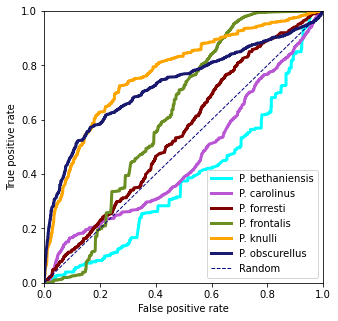

In [5]:
spec_labels=['B. wickershamorum', 'P. bethaniensis', 'P. carolinus', 'P. forresti', 'P. frontalis', 'P. knulli', 'P. obscurellus']
fig,ax=plt.subplots(1,1, figsize=(5, 5))
colormap = {0: 'dodgerblue', 1: 'cyan', 2: 'mediumorchid', 3: 'maroon',
                 4: 'olivedrab', 5: 'orange', 6: 'midnightblue'}


for i, sp in enumerate([df[df['species']==label].iloc[0].species_label for label in literature_labels]):
    fpr, tpr, thresholds = roc_curve(y_true, y_score[:,i].flatten(), pos_label=sp)
    lw = 3
    ax.plot(
        fpr,
        tpr,
        color=colormap[sp],
        lw=lw,
        label=spec_labels[sp],
    )
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
ax.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random")
plt.legend()
plt.show()

Plot confusion matrix.

[Text(0, 0.5, 'P. bethaniensis'),
 Text(0, 1.5, 'P. carolinus'),
 Text(0, 2.5, 'P. forresti'),
 Text(0, 3.5, 'P. frontalis'),
 Text(0, 4.5, 'P. knulli'),
 Text(0, 5.5, 'P. obscurellus')]

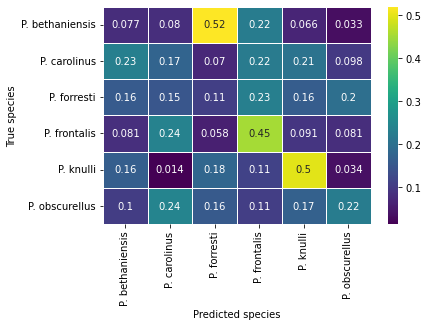

In [6]:
fig,ax = plt.subplots()
sns.heatmap(conf_mat, linewidths=1, cmap='viridis', ax=ax, annot=True, fmt='.2g')
ax.set_ylabel('True species')
ax.set_xlabel('Predicted species')
ax.set_xticklabels(spec_labels[1:], rotation=90)
ax.set_yticklabels(spec_labels[1:], rotation=0)


In [7]:
# Optional: pickle the output
import pickle
data = {
    "acc": acc,
    "prec": prec,
    "rec": rec,
    "conf_mat": conf_mat,
    "y_true": y_true,
    "y_pred": y_pred,
    "y_score": y_score,
    "metrics": metrics
}
with open("jaccard_lit", "wb") as f:
        pickle.dump(data, f)

## Classify using Jaccard index with population references.

In [3]:
# run for 60 folds
k = 60
train_split = 0.8
accs, precs, recs, conf_mat, y_true, y_pred, y_score, precs_sp, recs_sp = jaccardPop(df, k, train_split, 1)

In [4]:
spec_labels=['B. wickershamorum', 'P. bethaniensis', 'P. carolinus', 'P. forresti', 'P. frontalis', 'P. knulli', 'P. obscurellus']
print('Overall precision = {0:2.5f}'.format(np.mean(precs)))
print('Overall recall = {0:2.5f}'.format(np.mean(recs)))
for i in range(len(spec_labels)):
    print('{0} precision = {1:2.5f}, recall = {2:2.5f}'.format(spec_labels[i], np.mean(precs_sp[i]), np.mean(recs_sp[i])))

Overall precision = 0.40998
Overall recall = 0.48451
B. wickershamorum precision = 0.58407, recall = 0.16289
P. bethaniensis precision = 0.01238, recall = 0.85857
P. carolinus precision = 0.91185, recall = 0.14924
P. forresti precision = 0.08537, recall = 0.10714
P. frontalis precision = 0.82284, recall = 0.65719
P. knulli precision = 0.18851, recall = 0.82207
P. obscurellus precision = 0.26482, recall = 0.63451


Plot ROC curve.

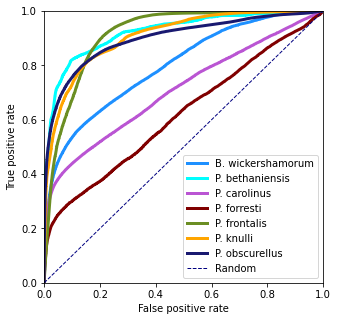

In [6]:
spec_labels=['B. wickershamorum', 'P. bethaniensis', 'P. carolinus', 'P. forresti', 'P. frontalis', 'P. knulli', 'P. obscurellus']
fig,ax=plt.subplots(1,1, figsize=(5, 5))
colormap = {0: 'dodgerblue', 1: 'cyan', 2: 'mediumorchid', 3: 'maroon',
                 4: 'olivedrab', 5: 'orange', 6: 'midnightblue'}

for sp in range(len(np.unique(df['species_label']))):
    fpr, tpr, thresholds = roc_curve(y_true, y_score[:,sp].flatten(), pos_label=sp)
    lw = 3
    ax.plot(
        fpr,
        tpr,
        color=colormap[sp],
        lw=lw,
        label=spec_labels[sp],
    )
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
ax.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random")
plt.legend()
plt.show()


Plot confusion matrix.

[Text(0, 0.5, 'B. wickershamorum'),
 Text(0, 1.5, 'P. bethaniensis'),
 Text(0, 2.5, 'P. carolinus'),
 Text(0, 3.5, 'P. forresti'),
 Text(0, 4.5, 'P. frontalis'),
 Text(0, 5.5, 'P. knulli'),
 Text(0, 6.5, 'P. obscurellus')]

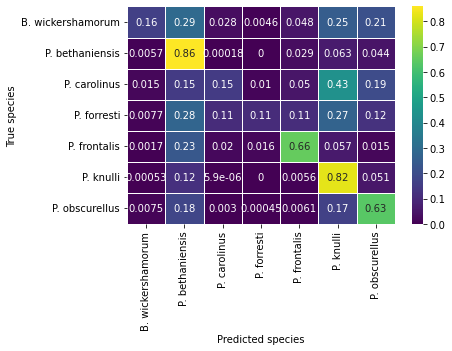

In [7]:
fig,ax = plt.subplots()
sns.heatmap(conf_mat, linewidths=1, cmap='viridis', ax=ax, annot=True, fmt='.2g')
ax.set_ylabel('True species')
ax.set_xlabel('Predicted species')
ax.set_xticklabels(spec_labels, rotation=90)
ax.set_yticklabels(spec_labels, rotation=0)

In [8]:
# Optional: pickle the output
import pickle
data = {
    "accs": accs,
    "precs": precs,
    "recs": recs,
    "conf_mat": conf_mat,
    "y_true": y_true,
    "y_pred": y_pred,
    "y_score": y_score,
    "precs_sp": precs_sp,
    "recs_sp": recs_sp
}
with open("jaccard_pop", "wb") as f:
        pickle.dump(data, f)